In [1]:
%matplotlib inline
from CartPole import CartPole, remap_angle, _remap_angle, _loss, loss, move_cart, generate_data, plot_y_contour_as_difference_in_x, range_x_pair_finder, plot_prediction_vs_actual_over_time, project_x_using_model, plot_y_scans
import numpy as np
import matplotlib.pyplot as plt

# Task 2

In [2]:
plot_path = 'plots/Task2/'
index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity', 4 : 'action'}
no_samples = 20
x_range_for_index = {0 : np.linspace(-5,5,no_samples), 1 : np.linspace(-10,10,no_samples), 
                     2 : np.linspace(-np.pi,np.pi,no_samples), 3 : np.linspace(-15,15,no_samples), 
                     4 : np.linspace(-20,20,no_samples)}
lam = 0.00001
n = 2000
no_RBC = 320
train_proportion = 0.8

In [3]:
def kernel(X, X_dash, sigma):

    if type(X) == list: X = np.array(X)
    if type(X_dash) == list: X_dash = np.array([X_dash])
    
    try:
        squared_numerator = np.array([(X[i]-X_dash[i])**2 if i != 2  else (np.sin((X[i]-X_dash[i])/2))**2 for i in range(5)])
    except:
        print(X, X_dash, '<------------ fix this')
    return np.exp(-np.sum(np.divide(squared_numerator, 2*np.square(sigma))))

In [4]:
def generate_K(X, M, sigma, kernel=kernel):
    if type(M) != list: M = np.array(M)
        
    for i,x_location in enumerate(X):
        K_row = np.array([kernel(x_location, RBF_x, sigma) for RBF_x in X[M]])
        try:
            KnM = np.vstack((KnM, K_row))
        except:
#             print('first row of K: {} <---------------------- this should only happen once'.format(K_row.shape))
            KnM = K_row
            
    return KnM

In [5]:
def train_alpha(x_train, y_train, no_RBC, sigma, kernel=kernel, lam=0.00001):
    
    M_vals = np.random.randint(0, high=n*train_proportion, size=no_RBC)
    X_i_vals = x_train[M_vals]
    KnM_ = generate_K(x_train, M_vals, sigma, kernel)
    KMM_ = generate_K(X_i_vals, [i for i in range(M_vals.size)], sigma, kernel)
    alpha = np.linalg.lstsq(np.matmul(KnM_.T, KnM_) + lam*KMM_, np.matmul(KnM_.T, y_train))[0]

#     alpha = np.linalg.lstsq(np.matmul(KnM_.T, KnM_), np.matmul(KnM_.T, y_train))[0]
#     alpha = np.matmul(np.linalg.pinv(KnM_), y_train).T
#     print('alpha.shape: {}'.format(alpha.shape))
    
    return alpha, X_i_vals

In [6]:
def predict(x_test, alpha, X_i_vals, sigma, kernel=kernel):
    
    KnM_test= [None, None]
    for X_i in X_i_vals:
        if x_test.size > 4:
            assert x_test.size % 5 == 0, 'x_test.size: ' + str(x_test.size)
            
            if x_test.ndim == 1:
                KnM_test_row = kernel(X_i, x_test, sigma=sigma)
            else:
                KnM_test_row = np.array([kernel(X_i, x_test_, sigma=sigma) for x_test_ in x_test])
            
        elif x_test.size == 4:
            if x_test.ndim > 1: x_test = x_test[0]
            KnM_test_row = kernel(X_i, x_test, sigma=sigma)
        try:
            KnM_test = np.vstack((KnM_test, KnM_test_row))
        except:
            KnM_test = KnM_test_row
    predictions = np.matmul(KnM_test.T, alpha)
    
    return predictions

In [7]:
def display_RMSE(predictions, y_test):
    targets = y_test            
    return [np.sqrt(np.mean((predictions[:,j]-targets[:,j])**2)) for j in range(4)] 

## plot convergence of model for varying no. basis functions

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys
C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we a

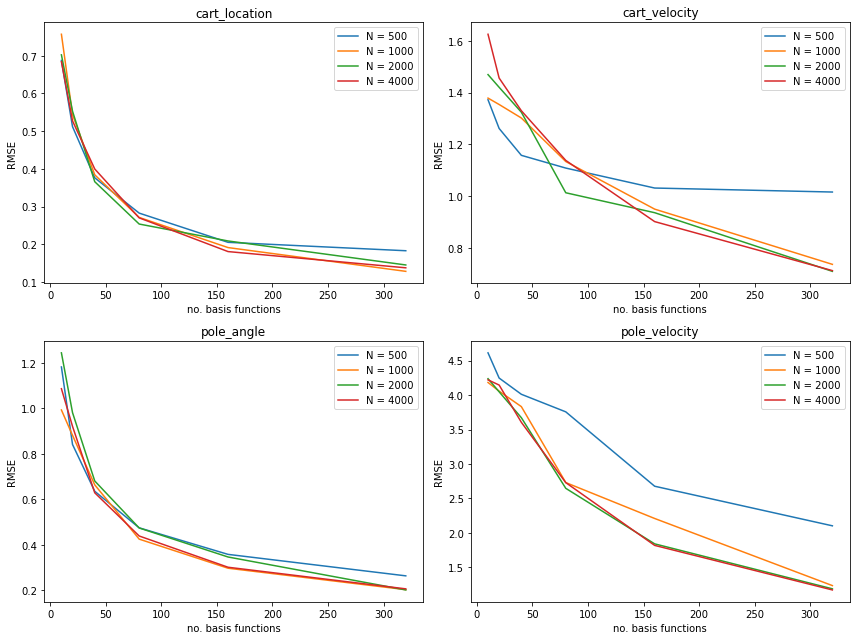

In [8]:
i_range = [10, 20, 40, 80, 160, 320] # list of no. radial basis functions to try
n_range = [500, 1000, 2000, 4000] # list of sizes of dataset to try

fig,axs = plt.subplots(2,2,figsize=(12,9))
for n in n_range:
    x,y = generate_data(n)
    x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
    sigma = np.std(x_train, axis=0)
    
    RMSE = None
    
    for i in i_range:
        alpha, X_i_vals = train_alpha(x_train, y_train, i, sigma)
        predictions = predict(x_test, alpha, X_i_vals, sigma)
        RMSE_ = np.array(display_RMSE(predictions, y_test))
        
        try:
            RMSE = np.vstack((RMSE, RMSE_))
        except:
            RMSE = RMSE_
    for j in range(4):
        axs[int(round((j+1)/4,0)),j%2].plot(i_range, RMSE[:,j], label='N = {}'.format(str(n)))
        axs[int(round((j+1)/4,0)),j%2].legend()
        axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
        axs[int(round((j+1)/4,0)),j%2].set_xlabel('no. basis functions')
        axs[int(round((j+1)/4,0)),j%2].set_ylabel('RMSE')
fig.tight_layout()
# plt.savefig(plot_path + 'convergence_of_non_linear_model')

## Plot model predictions vs actual values

In [21]:
x,y = generate_data(n)
x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
sigma = np.std(x_train, axis=0)

alpha, X_i_vals = train_alpha(x_train, y_train, no_RBC, sigma)
predictions = predict(x_test, alpha, X_i_vals, sigma)

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


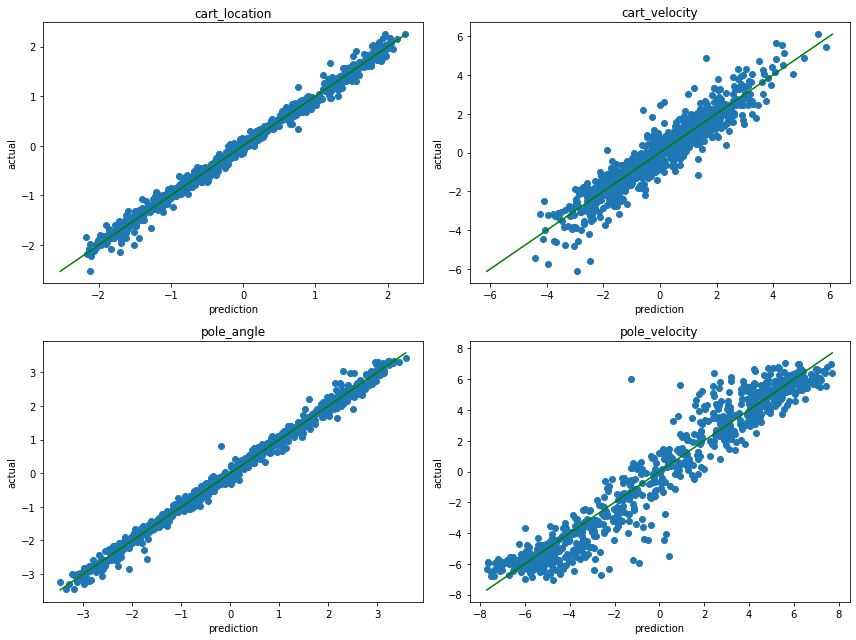

In [10]:
fig,axs = plt.subplots(2,2,figsize=(12,9))
for j in range(4):
    ul = max(max(predictions[:,j]), max(y_test[:,j]))
    ll = min(min(predictions[:,j]), min(y_test[:,j]))
    axs[int(round((j+1)/4,0)),j%2].scatter(predictions[:,j], y_test[:,j])
    axs[int(round((j+1)/4,0)),j%2].plot([ll,ul],[ll,ul], color='g')
    axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
    axs[int(round((j+1)/4,0)),j%2].set_xlabel('prediction')
    axs[int(round((j+1)/4,0)),j%2].set_ylabel('actual')
    
    fig.tight_layout()
    
# plt.savefig(plot_path + 'prediction_accuracy_with_action')

## Plot contours for non linear model

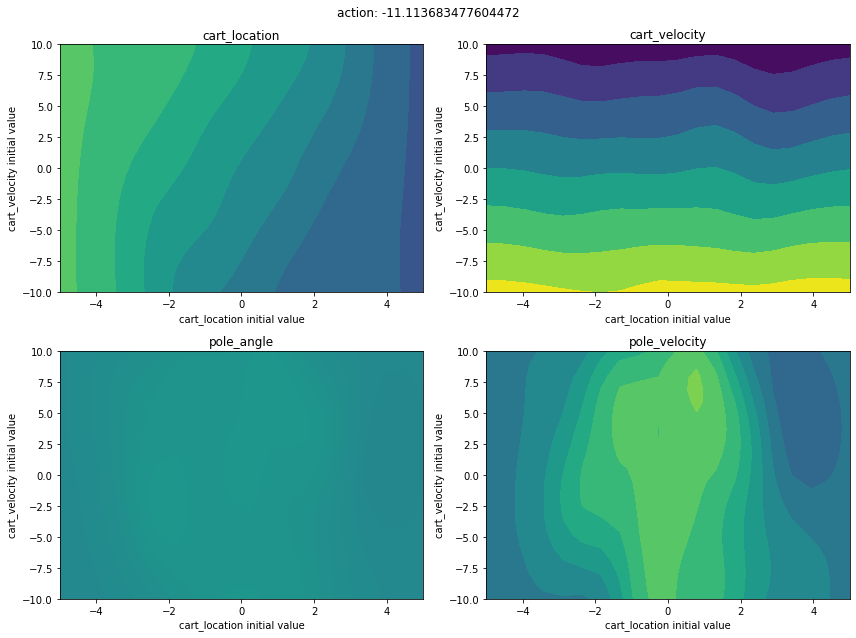

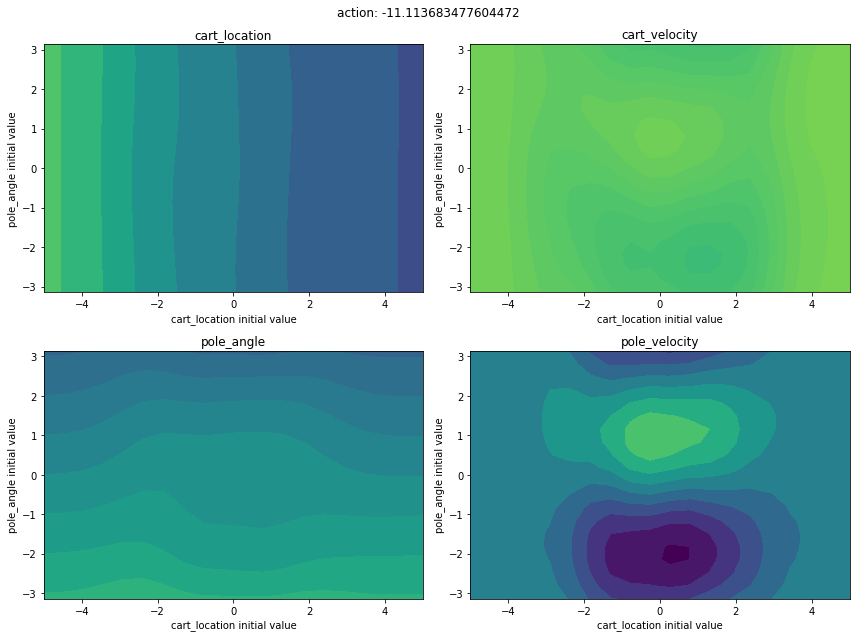

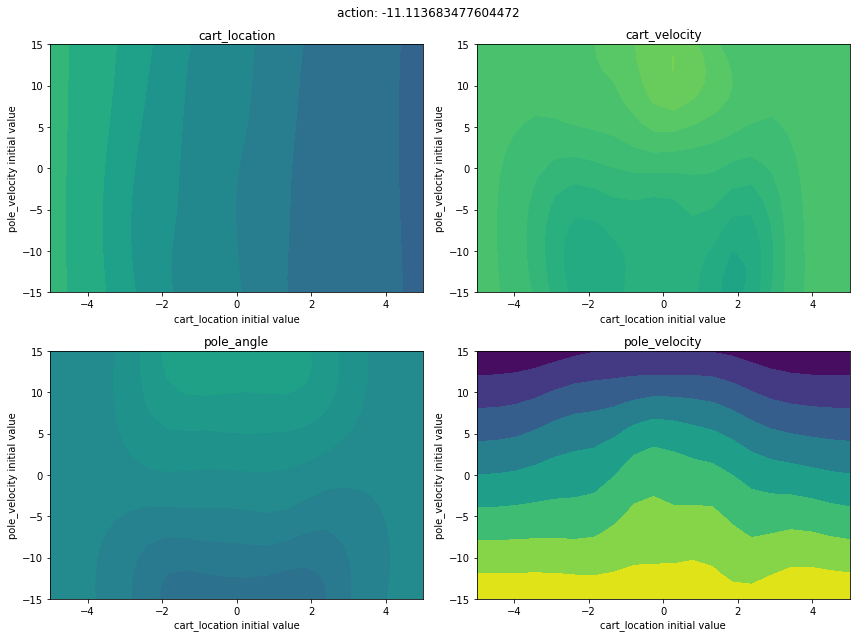

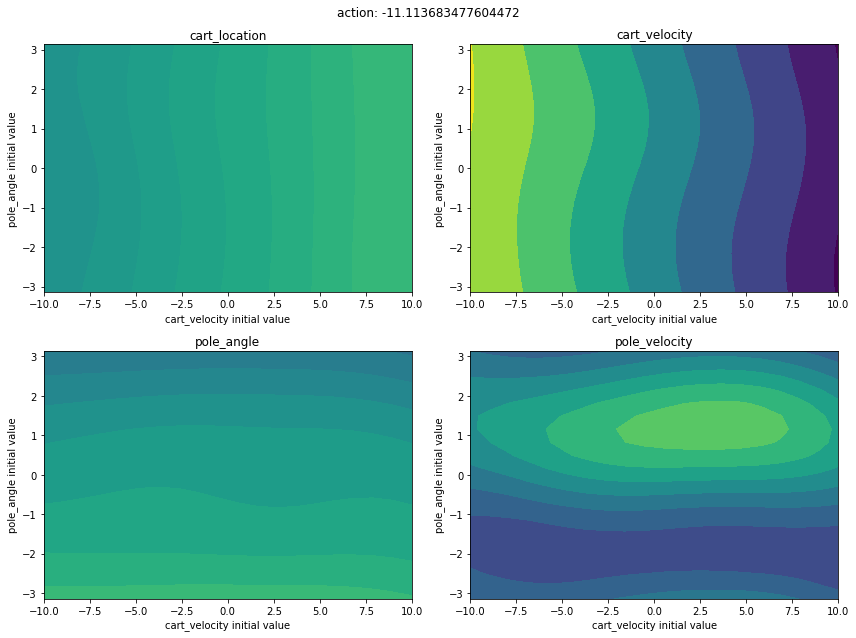

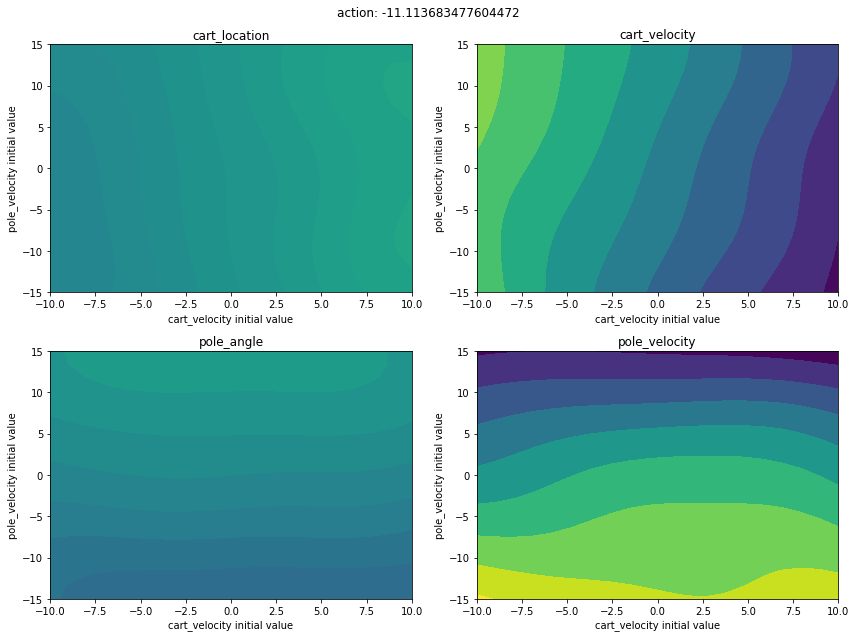

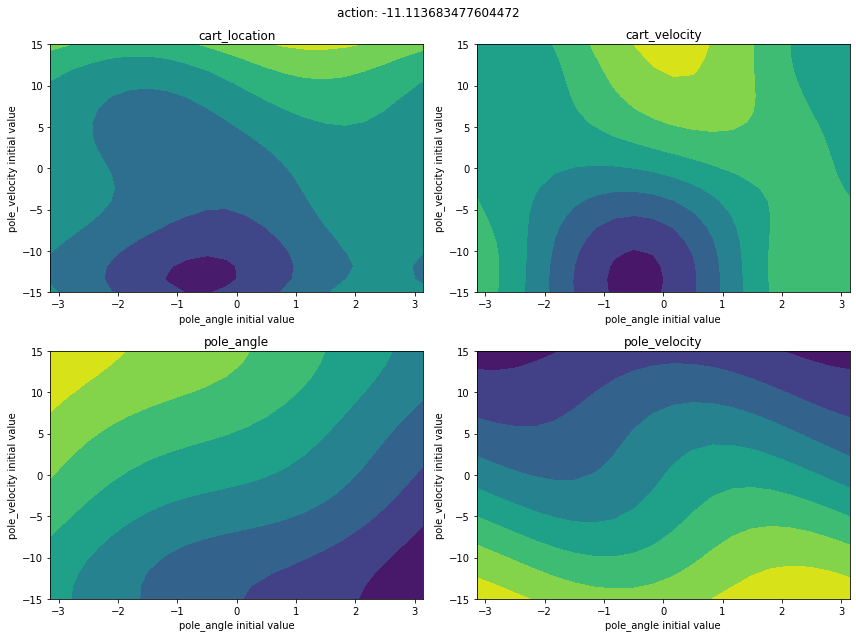

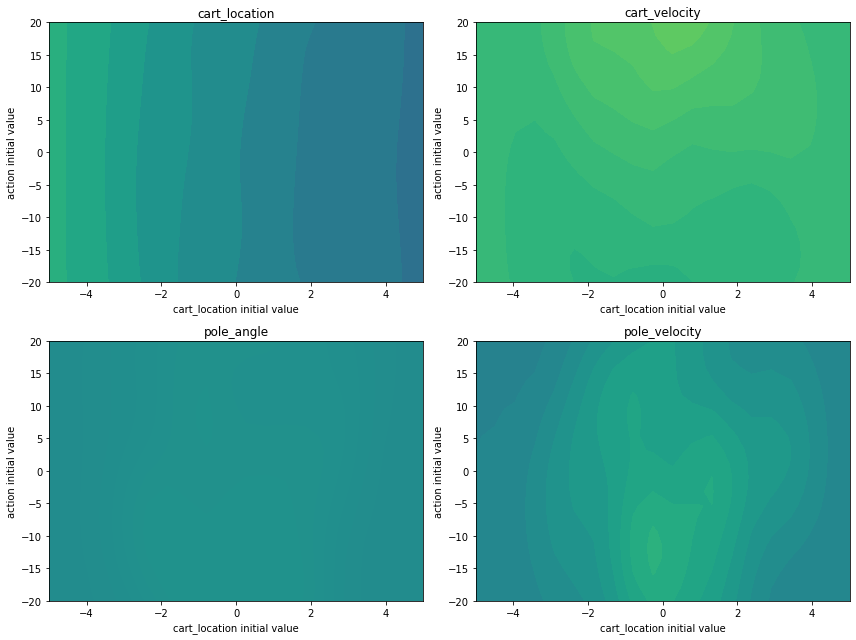

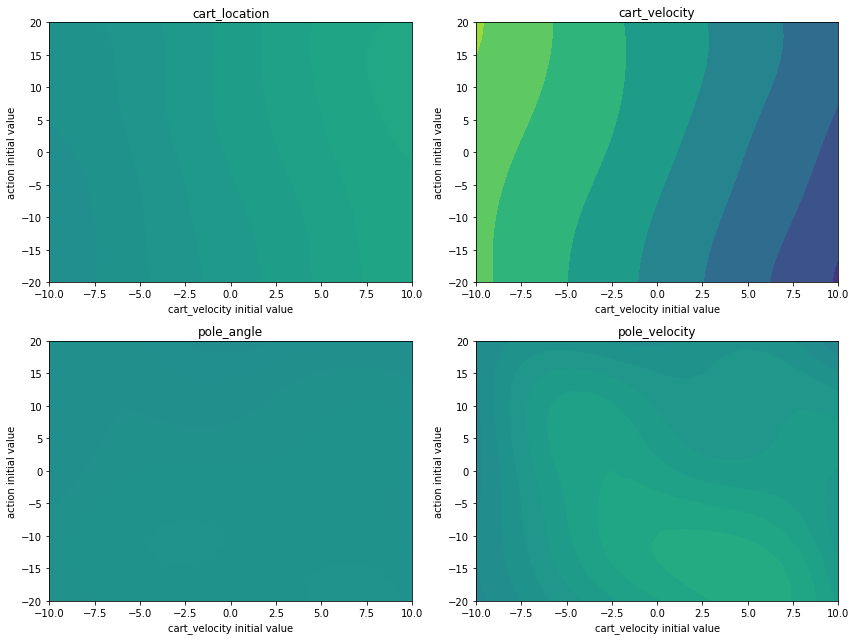

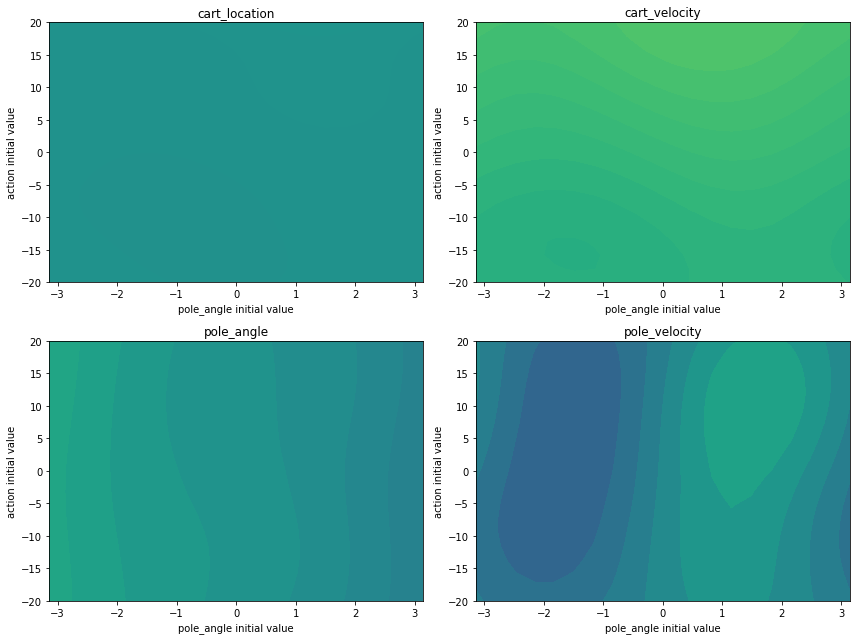

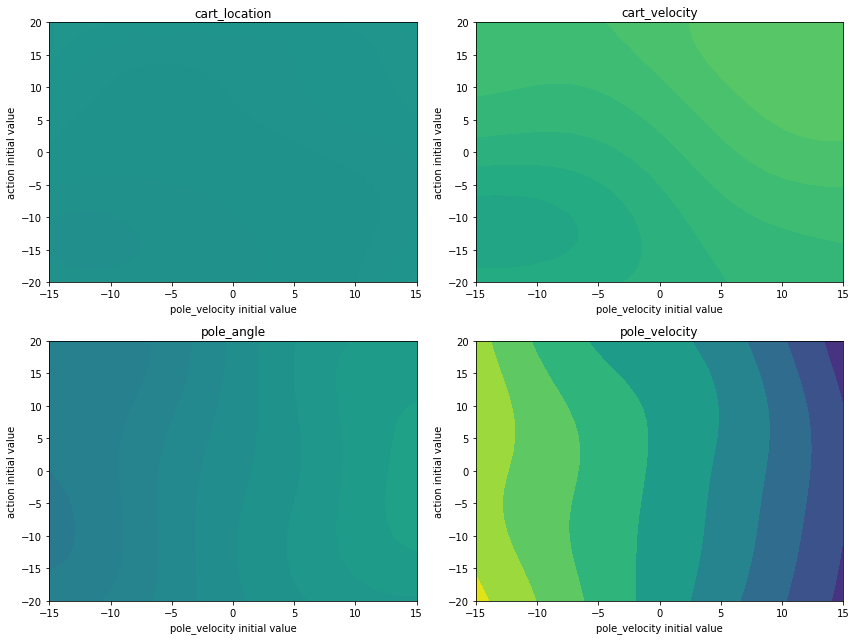

In [11]:
for index_pair in [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,4],[1,4],[2,4],[3,4]]:
    plot_y_contour_as_difference_in_x(x_test[0], index_pair, range_x_pair_finder(index_pair, x_range_for_index), 
                                      index_to_variable, dynamics='predicted', model=predict, alpha=alpha, 
                                      X_i_vals=X_i_vals, sigma=sigma)
#     plt.savefig(plot_path+'contour_plot_predictions_with_action'+str(index_pair))
#     plt.close()

## Testing different values of lambda

C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


action in project_x_using_model step 0 was 13.508119489511834
action in project_x_using_model step 1 was 13.508119489511834
action in project_x_using_model step 2 was 13.508119489511834
action in project_x_using_model step 3 was 13.508119489511834
action in project_x_using_model step 4 was 13.508119489511834
action in project_x_using_model step 5 was 13.508119489511834
action in project_x_using_model step 6 was 13.508119489511834
action in project_x_using_model step 7 was 13.508119489511834
action in project_x_using_model step 8 was 13.508119489511834
action in project_x_using_model step 9 was 13.508119489511834
action in project_x_using_model step 0 was 13.508119489511834
action in project_x_using_model step 1 was 13.508119489511834
action in project_x_using_model step 2 was 13.508119489511834
action in project_x_using_model step 3 was 13.508119489511834
action in project_x_using_model step 4 was 13.508119489511834
action in project_x_using_model step 5 was 13.508119489511834
action i

Text(0.5, 1.0, 'RMSE error for different values of lambda')

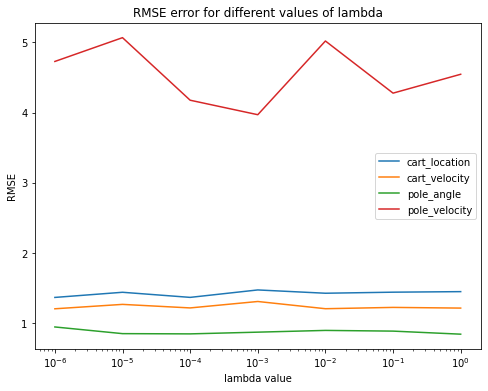

In [12]:
n = 500
x,y = generate_data(n)
x_train, y_train, x_test, y_test = x[:int(n*train_proportion)], y[:int(n*train_proportion)], x[int(n*train_proportion):], y[int(n*train_proportion):]
sigma = np.std(x_train, axis=0)
initial_x = x_test[0]

RMSE_data = []
for lam in [0.1**i for i in range(7)]:
    alpha, X_i_vals = train_alpha(x_train, y_train, 40, sigma, lam=lam)

    prediction_history, y_history = project_x_using_model(x[0], predict, steps=10, remap_angle=False, alpha=alpha, 
                                                           X_i_vals=X_i_vals, sigma=sigma)
    RMSE_data.append(display_RMSE(prediction_history, y_history))
    
RMSE_data = np.array(RMSE_data)

fig,ax = plt.subplots(1,1,figsize=(8,6))
for j in range(4):
    ax.plot([0.1**i for i in range(7)], RMSE_data[:,j], label=index_to_variable[j])
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('lambda value')
ax.set_ylabel('RMSE')
ax.set_title('RMSE error for different values of lambda')
# plt.savefig(plot_path + 'RMSE_different_lambda')

## Rollout with model prediction

[ 0.48807024  0.67720645 -2.62928638  7.48880641]


C:\Users\Jordan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


action in project_x_using_model step 0 was 19.346579919230955
action in project_x_using_model step 1 was 19.346579919230955
action in project_x_using_model step 2 was 19.346579919230955
action in project_x_using_model step 3 was 19.346579919230955
action in project_x_using_model step 4 was 19.346579919230955
action in project_x_using_model step 5 was 19.346579919230955
action in project_x_using_model step 6 was 19.346579919230955
action in project_x_using_model step 7 was 19.346579919230955
action in project_x_using_model step 8 was 19.346579919230955
action in project_x_using_model step 9 was 19.346579919230955


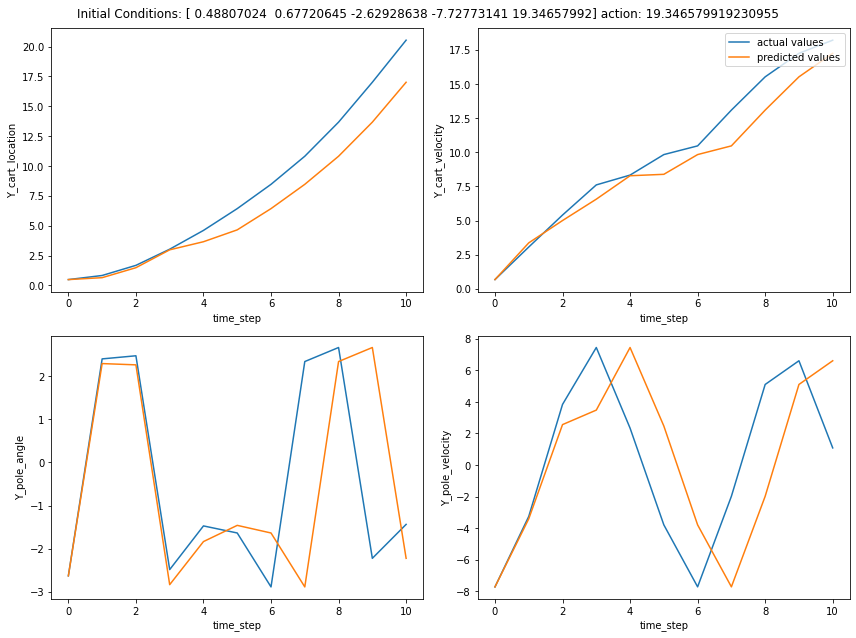

In [22]:
steps = 10

oscillating_initial_condition = np.array([x_test[0][i] if i != 3 else np.random.uniform(5,10) for i in range(4)])
print(oscillating_initial_condition)

sigma = np.std(x_train, axis=0)
alpha, X_i_vals = train_alpha(x_train, y_train, no_RBC, sigma)

prediction_history, y_history = project_x_using_model(x_test[0], predict, steps=steps, remap_angle=False, 
                                                      compound_predictions=False, alpha=alpha, 
                                                      X_i_vals=X_i_vals, sigma=sigma)

prediction_history[:,2] = np.array([_remap_angle(angle) for angle in prediction_history[:,2]])
y_history[:,2] = np.array([_remap_angle(angle) for angle in y_history[:,2]])

plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Initial Conditions: {}'.format(x_test[0]))
# plt.savefig(plot_path + 'model_rollout_prediction_with_action_{}_steps'.format(steps))

## Model performance scanning over 1 variable

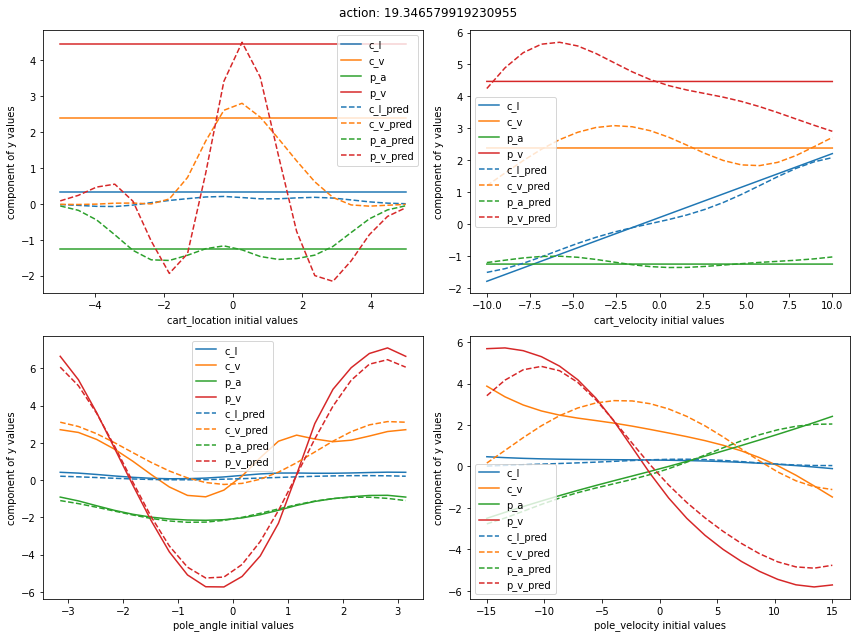

In [23]:
plot_y_scans(x_test[0], index_to_variable, x_range_for_index, predict, alpha=alpha, 
             X_i_vals=X_i_vals, sigma=sigma)
# plt.savefig(plot_path + 'model_accuracy_scan_over_1_variable_with_action')

## Introducing the loss function